<a href="https://colab.research.google.com/github/jittinabraham/retail_product_classification_kaggle_2021_text_alone/blob/main/kaggle_NLP_text_onlyipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir -p /root/.kaggle



In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"abraham88","key":"a9b79a70ac0e1c3be7469436ddbea6d6"}'}

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/


In [5]:
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle competitions download -c retail-products-classification

retail-products-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [8]:
!unzip retail-products-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/train/B001E6DLOQ.jpg  
  inflating: train/train/B001E6DM54.jpg  
  inflating: train/train/B001E6DMHW.jpg  
  inflating: train/train/B001E6FNQU.jpg  
  inflating: train/train/B001E6HVHO.jpg  
  inflating: train/train/B001E6HVOC.jpg  
  inflating: train/train/B001E6JCR6.jpg  
  inflating: train/train/B001E6LAH6.jpg  
  inflating: train/train/B001E6LAK8.jpg  
  inflating: train/train/B001E6LAUS.jpg  
  inflating: train/train/B001E6OCC6.jpg  
  inflating: train/train/B001E6TXCU.jpg  
  inflating: train/train/B001E6UUT0.jpg  
  inflating: train/train/B001E729CK.jpg  
  inflating: train/train/B001E76EJ4.jpg  
  inflating: train/train/B001E77NJ4.jpg  
  inflating: train/train/B001E77TUW.jpg  
  inflating: train/train/B001E8133K.jpg  
  inflating: train/train/B001E8D1BM.jpg  
  inflating: train/train/B001E8FXEK.jpg  
  inflating: train/train/B001E8ME5Q.jpg  
  inflating: train/train/B001E96MKI.jpg  
  inflating: train/train/

In [9]:
!pip install keras_metrics
!pip install --upgrade tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.8/489.8 MB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 66.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 101.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 43.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 83.8 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.15.0
    Uninstalling wrapt-1.15.0:
      Successfully uninstalled wrapt-1.15.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.13.0
    Uninstalling tensorflow-estimator-2.13.0:
      Successfully uninstalled tensorflow-estimator-2.13.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.3.1
    Uninstalling ml-dtypes-0.3.1:
      Successfully uninstalled ml-dtypes

In [10]:
from tensorflow.keras.layers import Input
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from tensorflow.keras.applications.mobilenet import MobileNet
from nltk.tokenize import word_tokenize
import gensim
import pandas as pd


import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
#import cv2
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from tensorflow.compat.v1.keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras_metrics
from keras.preprocessing.image import load_img, img_to_array
%matplotlib inline

In [11]:
CATEGORIES = ['Electronics', 'Sports & Outdoors',
       'Cell Phones & Accessories', 'Automotive', 'Toys & Games',
       'Tools & Home Improvement', 'Health & Personal Care', 'Beauty',
       'Grocery & Gourmet Food', 'Office Products',
       'Arts, Crafts & Sewing', 'Pet Supplies', 'Patio, Lawn & Garden',
       'Clothing, Shoes & Jewelry', 'Baby',
       'Musical Instruments', 'Industrial & Scientific', 'Baby Products',
       'Appliances', 'All Beauty', 'All Electronics']

In [12]:
data = pd.read_csv('train.csv')
pid = list(data['ImgId'])
descriptions = list(data['description'])
data.head()

,ImgId,title,description,categories
0,B000HYL1V6,TUNGSTEN SOLDER PICK WITH HANDLE,Solder Pick for picking up molten solder when ...,"Arts, Crafts & Sewing"
1,B00006HXWY,Write Right 98167 Screen Protector for Sony T615C,We all screen. And we all need to protect thos...,Cell Phones & Accessories
2,B000GAWSBS,Casio Mens DBC310-1 Databank 300 Digital Watch...,"Bringing you precision at a glance, the Casio ...","Clothing, Shoes & Jewelry"
3,B000040JOL,Factory-Reconditioned DEWALT DW260KR Heavy-Dut...,Factory-Reconditioned DEWALT DW260KR Heavy-Dut...,Tools & Home Improvement
4,B00006IB78,Energizer 2 in 1 Light,This twoway light features a bright flashlight...,Health & Personal Care


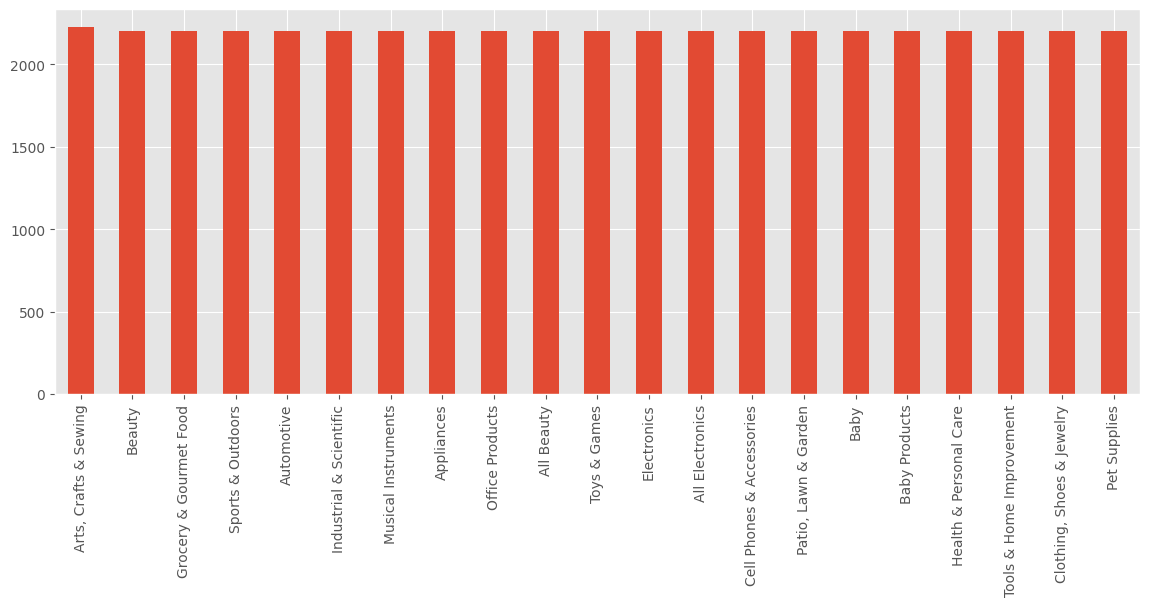

In [13]:
data['categories'].value_counts().plot(kind='bar', figsize=(14, 5));

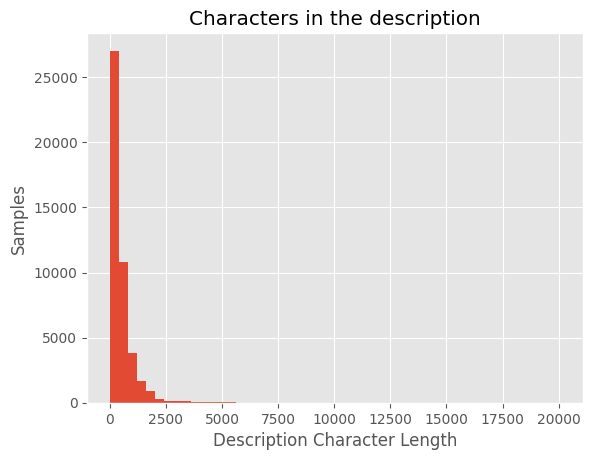

In [14]:
word_len=data['description'].str.len()
plt.hist(word_len, bins=50)
plt.ylabel('Samples')
plt.xlabel('Description Character Length')
plt.title('Characters in the description')
plt.show()

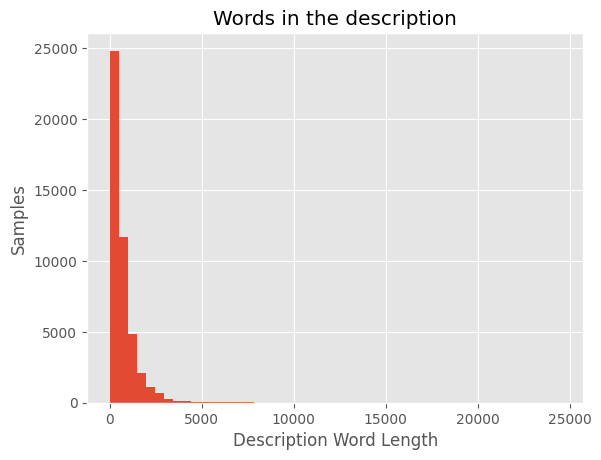

In [15]:
word_len=data['description'].str.split().map(lambda x: len(str(x)))
plt.hist(word_len, bins=50)
plt.ylabel('Samples')
plt.xlabel('Description Word Length');
plt.title('Words in the description')
plt.show()

In [16]:
train_images_path1 = 'train/train/train1'
train_images_path2 = 'train/train/train2'
train_images_path3 = 'train/train/train3'
IMG_SIZE = (80,80)
INPUT_SHAPE = IMG_SIZE + (3,)
CALLBACK_PATIENCE = 10
BATCH_SIZE = 32
NUM_EPOCHS = 30
VALIDATION_SPLIT = .2
NUM_CLASSES = len(CATEGORIES)
L2_REGULARIZATION = 0.01

In [17]:
# Create subfolders
train_images_path='train/train'
subfolder_names = ['train1', 'train2', 'train3']

for subfolder_name in subfolder_names:
    subfolder_path = os.path.join(train_images_path, subfolder_name)
    os.makedirs(subfolder_path, exist_ok=True)

In [18]:

import shutil

# Define the source directory with JPEG files
source_dir = '/content/train/train'  # Replace with your dataset path

# Define the three destination subfolders
destination_folders = ['/content/train/train/train1', '/content/train/train/train2', '/content/train/train/train3']

# Ensure the destination subfolders exist, or create them if they don't
for folder in destination_folders:
    os.makedirs(folder, exist_ok=True)

# List all JPEG files in the source directory
jpeg_files = [f for f in os.listdir(source_dir) if f.endswith('.jpg')]

# Calculate the number of files to move into each subfolder
num_files_per_subfolder = len(jpeg_files) // len(destination_folders)

# Move JPEG files into subfolders
for i, folder in enumerate(destination_folders):
    start_index = i * num_files_per_subfolder
    end_index = (i + 1) * num_files_per_subfolder if i < len(destination_folders) - 1 else None
    files_to_move = jpeg_files[start_index:end_index]
    for file in files_to_move:
        source_path = os.path.join(source_dir, file)
        destination_path = os.path.join(folder, file)
        shutil.move(source_path, destination_path)

print("JPEG files have been divided into subfolders.")

JPEG files have been divided into subfolders.


In [19]:
downloaded_files1 = []
for file in os.listdir(train_images_path1):
    if file.endswith(".jpg"):
        downloaded_files1.append(file.replace(".jpg", ""))
print(len(downloaded_files1))
downloaded_files2 = []
for file in os.listdir(train_images_path2):
    if file.endswith(".jpg"):
        downloaded_files2.append(file.replace(".jpg", ""))
print(len(downloaded_files2))
downloaded_files3 = []
for file in os.listdir(train_images_path3):
    if file.endswith(".jpg"):
        downloaded_files3.append(file.replace(".jpg", ""))
print(len(downloaded_files3))

14000
14000
14000


In [20]:
def create_training_data1(img):
    image1 = load_img(os.path.join(train_images_path1,img), grayscale=False, color_mode='rgb', target_size=(80,80))
    img_array1 = img_to_array(image1)
    return img_array1

def create_training_data2(img):
    image2 = load_img(os.path.join(train_images_path2,img), grayscale=False, color_mode='rgb', target_size=(80,80))
    img_array2 = img_to_array(image2)
    return img_array2

def create_training_data3(img):
    image3 = load_img(os.path.join(train_images_path3,img), grayscale=False, color_mode='rgb', target_size=(80,80))
    img_array3 = img_to_array(image3)
    return img_array3

In [21]:
def get_token(description):
        # split the description into tokens (words)
        tokens = set(gensim.utils.tokenize(description))
        # Avoid words does not have atleast 2 character
        tokens = [i for i in tokens if(len(i) > 2)]
        # Remove stop words
        tokens = [s for s in tokens if s not in stop_english]
        return tokens

In [22]:
def preprocess_input(x, v2=True):
    x = x.astype('float32')
    x = x / 255.0
    x = x - 0.5
    x = x * 2.0
    return x

In [23]:
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
stop_english=set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [24]:
corpus = []
images = []
labels = []
files = os.listdir(train_images_path1)
random.shuffle(files)

In [25]:
for img in files:
    img_id = img.split('.')[0]
    img_array = create_training_data1(img)
    if img_array is not None:
        try:
            index = data[data['ImgId']==img_id].index.values[0]
            row = data.iloc[index , :]
            family = row[3]
            if family in CATEGORIES:
                description = row[2]
                title = row[1]
                images.append(img_array.astype('float32'))
                token_list = get_token(str(title) + ' ' + str(description))
                corpus.append(token_list)
                class_num = CATEGORIES.index(family)
                labels.append(class_num)
        except IndexError as error:
            print(error)

images = np.asarray(images)
labels = pd.get_dummies(labels).values
images = preprocess_input(images)

In [26]:
files = os.listdir(train_images_path2)
random.shuffle(files)
corpus2 = []
images2 = []
labels2 = []
for img in files:
    img_id = img.split('.')[0]
    img_array2 = create_training_data2(img)
    if img_array2 is not None:
        try:
            index = data[data['ImgId']==img_id].index.values[0]
            row = data.iloc[index , :]
            family = row[3]
            if family in CATEGORIES:
                description = row[2]
                title = row[1]
                images2.append(img_array2.astype('float32'))
                token_list = get_token(str(title) + ' ' + str(description))
                corpus2.append(token_list)
                class_num = CATEGORIES.index(family)
                labels2.append(class_num)
        except IndexError as error:
            print(error)

images2 = np.asarray(images2)
labels2 = pd.get_dummies(labels2).values
images2 = preprocess_input(images2)

In [27]:
files = os.listdir(train_images_path3)
random.shuffle(files)
corpus3 = []
images3 = []
labels3 = []
for img in files:
    img_id = img.split('.')[0]
    img_array3 = create_training_data3(img)
    if img_array3 is not None:
        try:
            index = data[data['ImgId']==img_id].index.values[0]
            row = data.iloc[index , :]
            family = row[3]
            if family in CATEGORIES:
                description = row[2]
                title = row[1]
                images3.append(img_array2.astype('float32'))
                token_list = get_token(str(title) + ' ' + str(description))
                corpus3.append(token_list)
                class_num = CATEGORIES.index(family)
                labels3.append(class_num)
        except IndexError as error:
            print(error)

images3 = np.asarray(images3)
labels3 = pd.get_dummies(labels3).values
images3 = preprocess_input(images3)

In [28]:
combined_images = np.concatenate((images, images2,images3), axis=0)
combined_labels=np.concatenate((labels,labels2,labels3),axis=0)
combined_corpus=np.concatenate((corpus,corpus2,corpus3),axis=0)

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [29]:
del images
del images2
del images3
del index
del corpus
del corpus2
del corpus3

In [30]:
del token_list
del files
del title

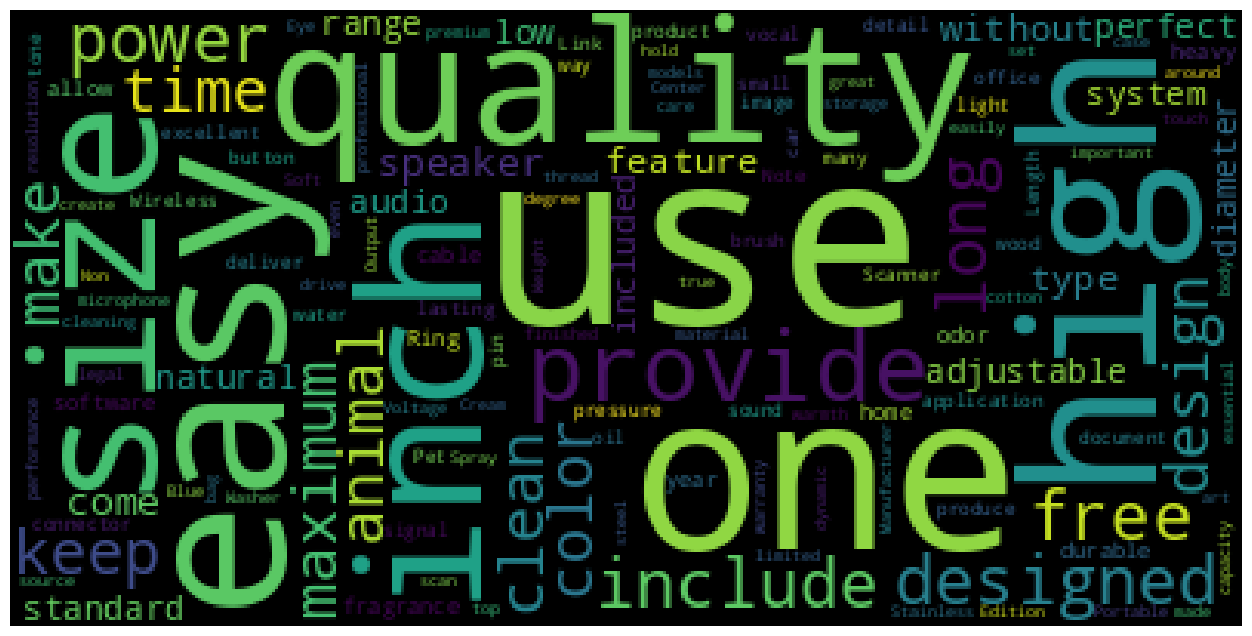

In [31]:
from wordcloud import WordCloud
plt.figure(figsize=(16,8))
text = [(" ").join(s) for s in combined_corpus]
word_cloud = WordCloud(
                          background_color='black',
                          max_font_size = 80
                         ).generate(" ".join(text[:50]))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

In [32]:
MAX_LEN=40
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(combined_corpus)
sequences=tokenizer_obj.texts_to_sequences(combined_corpus)

tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

word_index=tokenizer_obj.word_index

num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,300))

In [36]:
import gensim.downloader as api
model_fasttext = api.load("glove-wiki-gigaword-300")
known_words = []
unknown_words = []
for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue

    if word in model_fasttext:
        known_words.append(word)
        embedding_matrix[i] = model_fasttext[word]
    else:
        unknown_words.append(word)

[==================================================] 100.0% 376.1/376.1MB downloaded


100%|██████████| 72350/72350 [00:00<00:00, 218004.65it/s]


In [37]:
del model_fasttext
print(len(unknown_words))
print(len(known_words))

29676
42674


In [38]:
embedding_layer = tf.keras.layers.Embedding(num_words, 300, embeddings_initializer=Constant(embedding_matrix),
                                            input_length=MAX_LEN,trainable=False)
dropout = tf.keras.layers.SpatialDropout1D(0.2)
#lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2))
#lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))
lstm = tf.keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2)
dense = tf.keras.layers.Dense(200, activation='relu')
normalize = tf.keras.layers.BatchNormalization()

final_dropout = tf.keras.layers.Dropout(0.2)

dense_100 = tf.keras.layers.Dense(50, activation='relu')

output_layer = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')

embedding_model = tf.keras.Sequential([
    embedding_layer,
    dropout,
    lstm,
    dense,normalize,
    final_dropout,
    dense_100,
    output_layer
])
embedding_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 300)           21705300  
                                                                 
 spatial_dropout1d (Spatial  (None, 40, 300)           0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 64)                93440     
                                                                 
 dense (Dense)               (None, 200)               13000     
                                                                 
 batch_normalization (Batch  (None, 200)               800       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 200)               0

In [39]:
p =int((len(combined_images)*80)/100)
image_train =combined_images[:p]
image_test = combined_images[p:]
label_train = combined_labels[:p]
label_test =combined_labels[p:]
text_train = tweet_pad[:p]
text_test = tweet_pad[p:]

In [40]:
print('Shape of train',image_train.shape)
print("Shape of Validation ",image_test.shape)
print('Shape of train',label_train.shape)
print("Shape of Validation ",label_test.shape)
print("Shape of Text Train ",text_train.shape)

Shape of train (33600, 80, 80, 3)
Shape of Validation  (8400, 80, 80, 3)
Shape of train (33600, 21)
Shape of Validation  (8400, 21)
Shape of Text Train  (33600, 40)


In [41]:
from keras.preprocessing.image import ImageDataGenerator
# Define the image transformations here
gen = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = True,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,
                         zoom_range = 0.1,
                         rotation_range = 40)

def gen_flow_for_two_inputs(X1, X2, y):
    genX1 = gen.flow(X1, y, batch_size=BATCH_SIZE, shuffle=False)
    genX2 = gen.flow(X1, X2, batch_size=BATCH_SIZE, shuffle=False)
    i = 0
    while True:
            X1i = genX1.next()
            X2i = genX2.next()
            #np.testing.assert_array_equal(X1i[0],X2i[0])
            yield [X1i[0], X2i[1]], X1i[1]
            #yield X2i[1]

# Finally create generator
gen_flow = gen_flow_for_two_inputs(image_train, text_train, label_train)

In [43]:
regularization = tf.keras.regularizers.l2(L2_REGULARIZATION)

early_stop = EarlyStopping('val_loss', patience=CALLBACK_PATIENCE)
reduce_lr = ReduceLROnPlateau(
    'val_loss', factor=0.1, patience=int(CALLBACK_PATIENCE/4), verbose=1)
tensorboard = TensorBoard('./logs')
callbacks = [early_stop, reduce_lr, tensorboard]
#adam = tf.keras.optimizers.Adam(learning_rate=3e-4)
#optimizer = adam
embedding_model.compile(optimizer = 'adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
              #metrics=['accuracy', keras_metrics.precision(), keras_metrics.recall()])

In [44]:
!pip install scikit-learn
tf.debugging.set_log_device_placement(True)

In [46]:
try:

    history = embedding_model.fit( text_train, label_train, batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS, verbose=1, callbacks=callbacks, steps_per_epoch=len(text_train) // BATCH_SIZE, validation_data=(text_test, label_test))
except RuntimeError as e:
  print(e)

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'tensorflow.python.ops.init_ops.Constant'>, which may lead to improper serialization.
  warnings.warn(


Epoch 1/30
1050/1050 [==============================] - 92s 84ms/step - loss: 2.0958 - accuracy: 0.3356 - val_loss: 1.4673 - val_accuracy: 0.5274 - lr: 0.0010
Epoch 2/30
1050/1050 [==============================] - 89s 84ms/step - loss: 1.3972 - accuracy: 0.5493 - val_loss: 1.2112 - val_accuracy: 0.6174 - lr: 0.0010
Epoch 3/30
1050/1050 [==============================] - 89s 85ms/step - loss: 1.1958 - accuracy: 0.6147 - val_loss: 1.0537 - val_accuracy: 0.6588 - lr: 0.0010
Epoch 4/30
1050/1050 [==============================] - 90s 85ms/step - loss: 1.0914 - accuracy: 0.6469 - val_loss: 0.9898 - val_accuracy: 0.6792 - lr: 0.0010
Epoch 5/30
1050/1050 [==============================] - 89s 85ms/step - loss: 1.0152 - accuracy: 0.6746 - val_loss: 0.9532 - val_accuracy: 0.6948 - lr: 0.0010
Epoch 6/30
1050/1050 [==============================] - 90s 86ms/step - loss: 0.9644 - accuracy: 0.6877 - val_loss: 0.9157 - val_accuracy: 0.7085 - lr: 0.0010
Epoch 7/30
1050/1050 [========================